# Brain Stroke Prediction

## Importing Necessary Libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as SSSplit
from imblearn.ensemble import BalancedBaggingClassifier
from scipy.integrate import simps
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import fbeta_score
from collections import OrderedDict

In [2]:
# This code checks if a file named "brain_stroke.csv" exists in the current directory using the `os.path.exists()` function. If the file exists, it prints "Already Present". If the file does not exist, it downloads the file from a Dropbox link using the `!wget` command.
if os.path.exists('brain_stroke.csv'):
    print("Alreday Present")
else:
    !wget https://www.dropbox.com/s/fpymf1avgdhx31i/brain_stroke.csv

--2023-04-30 18:19:55--  https://www.dropbox.com/s/fpymf1avgdhx31i/brain_stroke.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fpymf1avgdhx31i/brain_stroke.csv [following]
--2023-04-30 18:19:55--  https://www.dropbox.com/s/raw/fpymf1avgdhx31i/brain_stroke.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4886af35023e7d2379d18e5ac4.dl.dropboxusercontent.com/cd/0/inline/B7JGPFuBSWixPvVqRxqpGlo3yQQaHF3SDeJnez4SVvKl_JiX_dPllBAXCdPZNDrFjda95QIn6potMtDp5IrBvV63rexviDh8d1KR6x5dYDLCPNvVmea0f7pggEkOI6dkj0YCk2LvMvRcaLSKRSCnYiANudXPV70nMk7pyHeKFfRcKA/file# [following]
--2023-04-30 18:19:56--  https://uc4886af35023e7d2379d18e5ac4.dl.dropboxusercontent.com/cd/0/inline/B7JGPFuBSWixPvVqRxqpGlo3yQQaHF3SDeJnez4SVvKl_JiX_dPllBAXCdPZNDrFjda9

## Data Visualization

In [3]:
# `df=pd.read_csv('brain_stroke.csv')` is reading a CSV file named "brain_stroke.csv" and storing its contents in a pandas DataFrame called `df`.
df=pd.read_csv('brain_stroke.csv')

In [4]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [5]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [6]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
for col in df.columns:
    print("column:  {:18s} |    unique element cnt: {}".format(col, len(np.unique(df[col]))))

column:  gender             |    unique element cnt: 2
column:  age                |    unique element cnt: 104
column:  hypertension       |    unique element cnt: 2
column:  heart_disease      |    unique element cnt: 2
column:  ever_married       |    unique element cnt: 2
column:  work_type          |    unique element cnt: 4
column:  Residence_type     |    unique element cnt: 2
column:  avg_glucose_level  |    unique element cnt: 3895
column:  bmi                |    unique element cnt: 342
column:  smoking_status     |    unique element cnt: 4
column:  stroke             |    unique element cnt: 2


In [8]:
col_to_encode=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in col_to_encode:
    encoder=LabelEncoder()
    df[i]=encoder.fit_transform(df[i])
    print(f"{i} encoding: {dict(zip(encoder.classes_, range(len(encoder.classes_))))}")

gender encoding: {'Female': 0, 'Male': 1}
ever_married encoding: {'No': 0, 'Yes': 1}
work_type encoding: {'Govt_job': 0, 'Private': 1, 'Self-employed': 2, 'children': 3}
Residence_type encoding: {'Rural': 0, 'Urban': 1}
smoking_status encoding: {'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}


In [9]:
df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,0.416382,43.419859,0.096165,0.055210,0.658502,1.302349,0.508332,105.943562,28.498173,1.379442,0.049789
std,0.493008,22.662755,0.294848,0.228412,0.474260,0.860170,0.499981,45.075373,6.790464,1.072180,0.217531
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,14.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,77.230000,23.700000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,1.000000,91.850000,28.100000,2.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,2.000000,1.000000,113.860000,32.600000,2.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,3.000000,1.000000,271.740000,48.900000,3.000000,1.000000


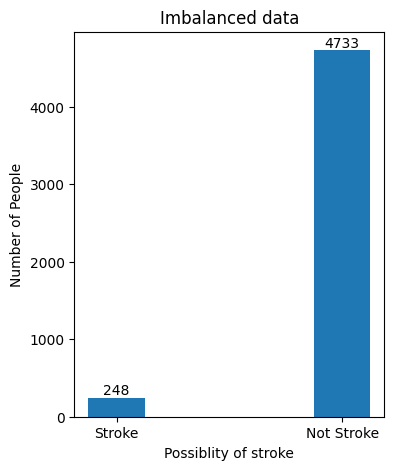

In [10]:
height = [len(df[df["stroke"] == 1]), len(df[df["stroke"] == 0])]
plt.figure(figsize=(4, 5))
plt.bar(["Stroke","Not Stroke"],height,width = 0.25)
plt.text(0, height[0], str(height[0]), ha="center", va="bottom")
plt.text(1, height[1], str(height[1]), ha="center", va="bottom")
plt.xlabel("Possiblity of stroke")
plt.ylabel("Number of People")
plt.title("Imbalanced data")
plt.show()

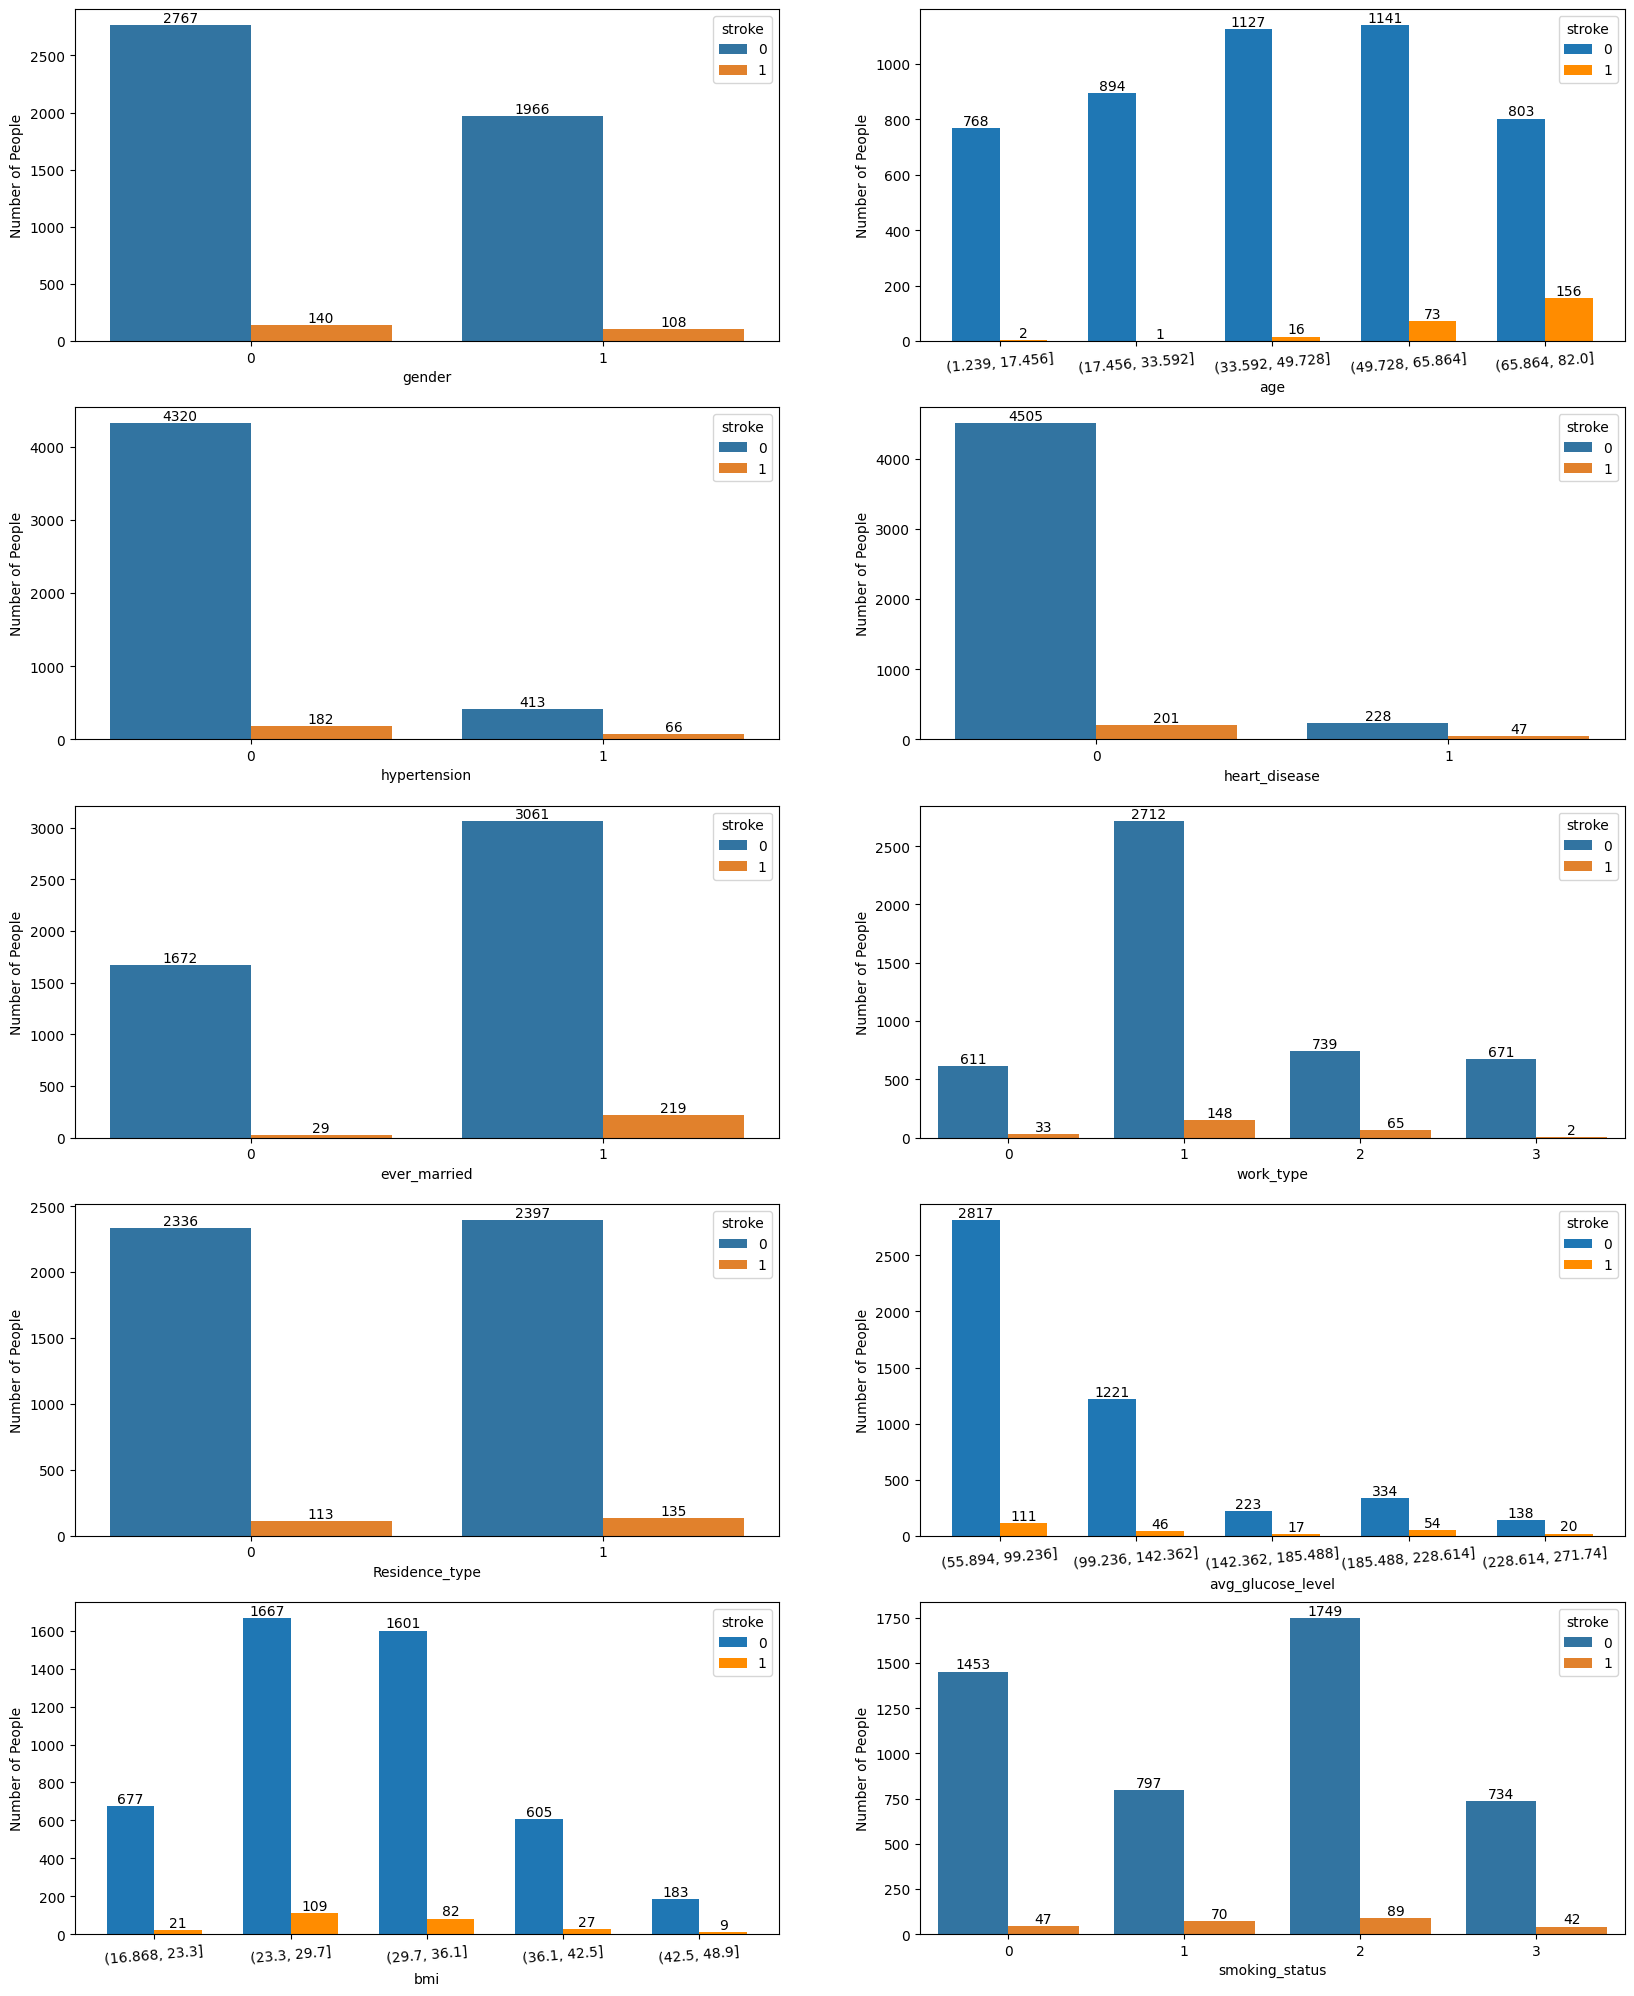

In [11]:
fig = plt.figure(figsize=(20, 25))
cnt = 0
temp = df
for i in df.columns[:-1]:
    if i in ["age", "avg_glucose_level", "bmi"]:
        cnt += 1
        ax = fig.add_subplot(5, 2, cnt)
        plt.xlabel(i)
        plt.ylabel("Number of People")
        bin_counts_1 = pd.cut(temp[i][temp["stroke"] == 1], bins=5).value_counts().sort_index()
        bin_counts_0 = pd.cut(temp[i][temp["stroke"] == 0], bins=5).value_counts().sort_index()
        bar_width = 0.35
        x_labels = bin_counts_1.index.values.astype(str)
        x = np.arange(len(x_labels))
        ax.bar(x - bar_width/2, bin_counts_0.values, width=bar_width, label="0",alpha = 1.0)
        ax.bar(x + bar_width/2, bin_counts_1.values, width=bar_width, label="1", color='darkorange',alpha = 1.0)
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=5)
        for j, v2, v1 in zip(x, bin_counts_1.values, bin_counts_0.values):
            ax.annotate(str(v1), xy=(j - bar_width/2, v1), ha='center', va='bottom', color='black')
            ax.annotate(str(v2), xy=(j + bar_width/2, v2), ha='center', va='bottom', color='black')
        plt.legend(title = "stroke")
    else:
        cnt += 1
        ax = fig.add_subplot(5, 2, cnt)
        sns.countplot(data=temp, x=i, hue="stroke", ax=ax)
        plt.xlabel(i)
        plt.ylabel("Number of People")
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

In [12]:
#Scalling the dataset
scaler = MinMaxScaler()
for col in df.columns:
    if(col!='stroke'):
        df[col] = scaler.fit_transform(np.array(df[col]).reshape(len(df[col]),1))

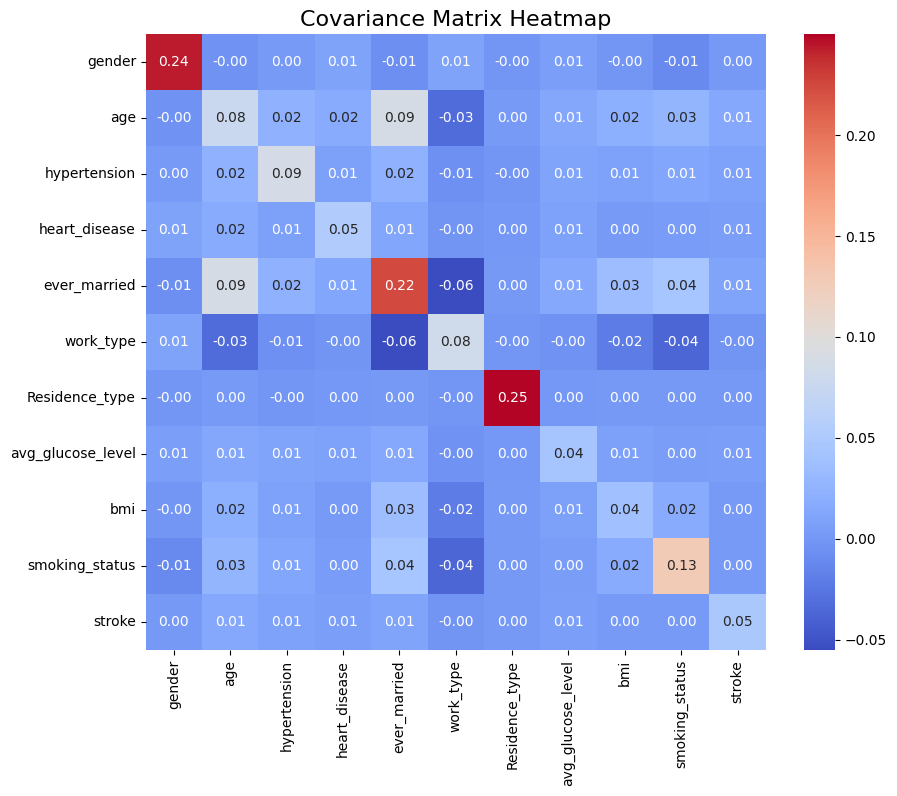

In [13]:
cov_matrix=df.cov()
plt.figure(figsize=(10, 8)) 
sns.heatmap(cov_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Covariance Matrix Heatmap', fontsize=16)

# Show plot
plt.show()

In [14]:
X=df.drop('stroke',axis=1).to_numpy()
y=df['stroke'].to_numpy()



In [15]:
model_selection_dict = {}
beta=2

## Splitting dat into test train and validation sets

In [16]:

X_train,X_temp,y_train,y_temp=tts(X,y,test_size=0.3,stratify=y)
X_val,X_test,y_val,y_test = tts(X_temp,y_temp,test_size=2/3,stratify=y_temp)
print(X_train.shape,X_val.shape)
X_train_not_sampled,y_train_not_sampled=X_train,y_train

(3486, 10) (498, 10)


## Oversampling the training data

In [17]:
smk = SMOTETomek(sampling_strategy='minority', random_state=42)
X_train, y_train = smk.fit_resample(X_train, y_train)
print(X_train)
print("After Oversampling:")
print("Risk", Counter(y_train))

[[0.         0.53613281 0.         ... 0.7422214  0.7965616  1.        ]
 [1.         0.82910156 0.         ... 0.41607423 0.50143266 0.66666667]
 [0.         0.51171875 0.         ... 0.19693472 0.45272206 0.        ]
 ...
 [0.         0.67817768 1.         ... 0.74920318 0.92706531 0.66666667]
 [0.         0.90063364 0.         ... 0.09977326 0.45501583 0.8866652 ]
 [1.         0.92250673 1.         ... 0.77841652 0.34259084 0.95654989]]
After Oversampling:
Risk Counter({0: 3281, 1: 3281})


In [18]:
len(X_train)

6562

## Naive Bayes

In [ ]:
CNB_clf=ComplementNB().fit(X_train,y_train)
y_pred=CNB_clf.predict(X_val)
print("Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))
model_selection_dict["Naive Bayes(Complement)"] = fbeta_score(y_val,y_pred,beta = beta)

Classification Report 

               precision    recall  f1-score   support

  not stroke       0.98      0.78      0.87       473
      stroke       0.16      0.76      0.26        25

    accuracy                           0.78       498
   macro avg       0.57      0.77      0.57       498
weighted avg       0.94      0.78      0.84       498



In [ ]:
print("Confusion Matrix \n\n",confusion_matrix(y_val,y_pred))

Confusion Matrix 

 [[371 102]
 [  6  19]]


## Random Forest Classifier

In [ ]:
# RFC_clf=RandomForestClassifier()
# parameters={
#     'n_estimators':[50,100,200],
#     'criterion':['gini','entropy'],
#     'max_depth': [10,50,100],
#     'bootstrap': [True,False]
# }
# clf=RandomizedSearchCV(RFC_clf,parameters,random_state=42)
# search=clf.fit(X_train,y_train)
# best_params=search.best_params_
# print(search.best_params_)

In [ ]:
# RFC_clf=RandomForestClassifier(**best_params)
# RFC_clf.fit(X_train,y_train)
# RFC_ypred=RFC_clf.predict(X_val)
# print(RFC_clf.score(X_val,y_val))

In [ ]:
# print(classification_report(y_val,RFC_ypred,target_names=['not stroke','stroke']))

In [ ]:
# sns.heatmap(confusion_matrix(y_val,RFC_ypred),annot=True,cmap='Blues')

In [ ]:
# f1_score(y_val,RFC_ypred)

## Balanced Bagging Classifier

In [ ]:
classifier_BBC = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
classifier_BBC.fit(X_train, y_train)
preds = classifier_BBC.predict(X_val)
print("fbeta-score for Balanced Bagging Classifier is",fbeta_score(y_val,preds,beta = beta))
model_selection_dict["Balanced Bagging Classifier"] = fbeta_score(y_val,preds,beta=beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,preds,target_names=['not stroke','stroke']))

fbeta-score for Balanced Bagging Classifier is 0.2173913043478261
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.96      0.93      0.95       473
      stroke       0.16      0.24      0.19        25

    accuracy                           0.90       498
   macro avg       0.56      0.59      0.57       498
weighted avg       0.92      0.90      0.91       498



In [ ]:
def plot_roc_curve(clf,X,y,classes):
    y_probas=clf.predict_proba(X)
    auc_s=[]
    for idx,class_no in enumerate(classes):
        y_true=np.where(y==class_no,1,0)
        y_probs=y_probas[:,idx]
        thresholds=np.sort(y_probs)[::-1]
        tpr=[]
        fpr=[]
        for thres in thresholds:
            y_pred=np.where(y_probs>=thres,1,0)
            tn,fp,fn,tp=confusion_matrix(y_true,y_pred).ravel()
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
        auc=np.trapz(tpr,fpr)
        auc_s.append(auc)
        plt.plot(fpr,tpr,label=class_no,alpha=0.5,lw=5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend(bbox_to_anchor=(1.15, 1.05))
    plt.show()
    print("AUC: ",auc_s)

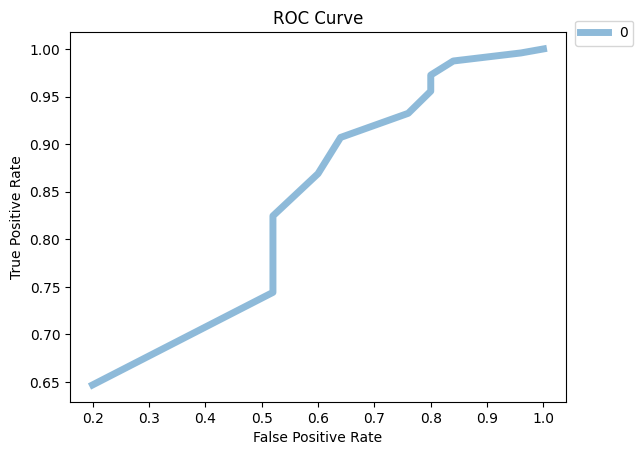

AUC:  [0.6720507399577167]


In [ ]:
plot_roc_curve(classifier_BBC,X_val,y_val,[0])

In [ ]:
y_prob=classifier_BBC.predict_proba(X_val)[:,1]

In [ ]:
y_pred=[1 if y_proba>0.4 else 0 for y_proba in y_prob]

0.34843205574912894 0.0


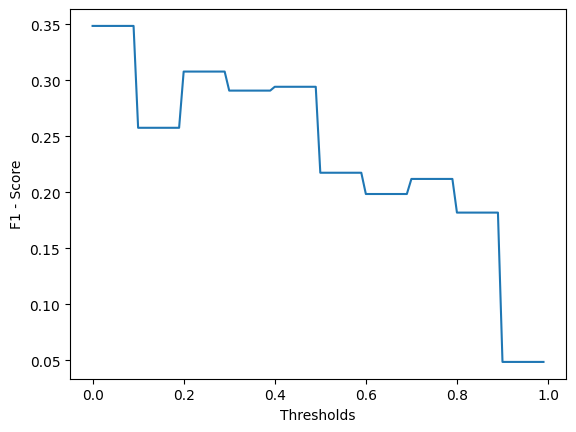

In [ ]:
best_f1_score=-1
best_thres=-1
score_arr  = []
for thres in np.arange(0,1,0.01):
    y_pred=[1 if y_proba>thres else 0 for y_proba in y_prob]
    score=fbeta_score(y_val,y_pred,beta=beta)
    if(score>best_f1_score):
        best_f1_score=score
        best_thres=thres
    score_arr.append(score)
print(best_f1_score,best_thres)
plt.xlabel("Thresholds")
plt.ylabel("F1 - Score")
plt.plot(np.arange(0,1,0.01),score_arr)

In [ ]:
y_pred=[1 if y_proba>best_thres else 0 for y_proba in y_prob]
print("Classification Report\n\n",classification_report(y_val,y_pred))

Classification Report

               precision    recall  f1-score   support

           0       0.98      0.65      0.78       473
           1       0.11      0.80      0.19        25

    accuracy                           0.65       498
   macro avg       0.55      0.72      0.48       498
weighted avg       0.94      0.65      0.75       498



## Bagging Classifier

In [ ]:
classifier_BC=BaggingClassifier(estimator=SVC(),n_estimators=10,random_state=42).fit(X_train,y_train)
print("fbeta-score for Bagging Classifier",fbeta_score(y_val,classifier_BC.predict(X_val),beta  = beta))
model_selection_dict["Bagging Classifier"] = fbeta_score(y_val,classifier_BC.predict(X_val),beta = beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,classifier_BC.predict(X_val),target_names=['not stroke','stroke']))

fbeta-score for Bagging Classifier 0.3009259259259259
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.97      0.78      0.87       473
      stroke       0.11      0.52      0.18        25

    accuracy                           0.77       498
   macro avg       0.54      0.65      0.52       498
weighted avg       0.93      0.77      0.83       498



## Ratio of Majority vs Miniority Class Points

In [ ]:
len(np.where(y_train_not_sampled==0)[0])/len(np.where(y_train_not_sampled==1)[0])

19.03448275862069

## Voting Ensemble

In [ ]:
n_estimators=19
minority_indices=np.where(y_train_not_sampled==1)[0]
majority_indices=np.where(y_train_not_sampled==0)[0]
n=len(minority_indices)
np.random.shuffle(majority_indices)
start=0
end=n+1
voting_ensemble=[]
while(end<len(majority_indices)):
    train_data_indices=np.array(minority_indices)
    train_data_indices=np.append(train_data_indices,majority_indices[start:end])
    clf=DecisionTreeClassifier()
    clf.fit(X_train_not_sampled[train_data_indices],y_train_not_sampled[train_data_indices])
    voting_ensemble.append(clf)
    start+=n
    end+=n
train_data_indices=np.array(minority_indices)
train_data_indices=np.append(train_data_indices,majority_indices[start:])
clf=DecisionTreeClassifier()
clf.fit(X_train_not_sampled[train_data_indices],y_train_not_sampled[train_data_indices])
voting_ensemble.append(clf)

In [ ]:
def pred_ensemble(voting_ensemble,X_val):
    n=len(voting_ensemble)
    predictions=voting_ensemble[0].predict(X_val)
    for i in range(1,n):
        predictions+=voting_ensemble[i].predict(X_val)
    y_pred=[1 if pred>n/2 else 0 for pred in predictions]
    print(n)
    return y_pred


def pred_proba_ensemble(voting_ensemble,X_val):
    n=len(voting_ensemble)
    proba=voting_ensemble[0].predict_proba(X_val)
    for i in range(1,n):
        proba+=voting_ensemble[i].predict_proba(X_val)   
    proba=proba/n
    return proba

In [ ]:
y_pred=pred_ensemble(voting_ensemble,X_val)
print("Confusion Matrix \n\n",confusion_matrix(y_val,y_pred))

20
Confusion Matrix 

 [[325 148]
 [  3  22]]


In [ ]:
print("Classification Report \n\n",classification_report(y_val,y_pred))

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.69      0.81       473
           1       0.13      0.88      0.23        25

    accuracy                           0.70       498
   macro avg       0.56      0.78      0.52       498
weighted avg       0.95      0.70      0.78       498



In [ ]:
print("Accuracy for Voting Ensemble",accuracy_score(y_val,y_pred))
model_selection_dict["Voting Emsemble"] = fbeta_score(y_val,y_pred,beta = beta)

Accuracy for Voting Ensemble 0.6967871485943775


In [ ]:
print("Confusion Matrix \n\n",confusion_matrix(y_val,y_pred))

Confusion Matrix 

 [[325 148]
 [  3  22]]


In [ ]:
print("fbeta_score",fbeta_score(y_val,y_pred,beta=beta))

fbeta_score 0.40740740740740744


## Support Vector Classifier

### SVC on undersampled data

In [ ]:
minority_indices=np.where(y_train_not_sampled==1)[0]
majority_indices=np.where(y_train_not_sampled==0)[0]
indices=np.append(minority_indices,np.random.choice(majority_indices,len(minority_indices)))
temp_X_train=X_train_not_sampled[indices]
temp_y_train=y_train_not_sampled[indices]
clf_svc=SVC(kernel='linear',probability=True).fit(temp_X_train,temp_y_train)
print("Confusion Matrix \n\n",confusion_matrix(y_val,clf_svc.predict(X_val)))

Confusion Matrix 

 [[336 137]
 [  2  23]]


In [ ]:
print("fbeta-score for SVC is",fbeta_score(y_val,clf.predict(X_val),beta=beta))
model_selection_dict["SVC(undersampled)"] = fbeta_score(y_val,clf_svc.predict(X_val),beta = beta)

fbeta-score for SVC is 0.2971576227390181


In [ ]:
print("Classification Report \n\n",classification_report(y_val,clf_svc.predict(X_val)))

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.71      0.83       473
           1       0.14      0.92      0.25        25

    accuracy                           0.72       498
   macro avg       0.57      0.82      0.54       498
weighted avg       0.95      0.72      0.80       498



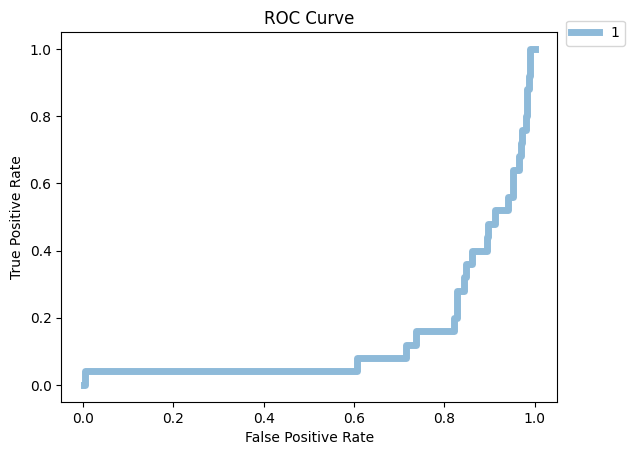

AUC:  [0.14156448202959832]


In [ ]:
plot_roc_curve(clf_svc,X_val,y_val,[1])

### SVC on oversampled data

In [ ]:
clf_svc_over=SVC(kernel='linear').fit(X_train,y_train)
model_selection_dict["SVC(oversampled)"] = fbeta_score(y_val,clf_svc_over.predict(X_val),beta = beta)

In [ ]:
print("fbeta-score for SVC is",fbeta_score(y_val,clf_svc_over.predict(X_val),beta=beta))

fbeta-score for SVC is 0.398406374501992


## MLP Classifier

In [ ]:
clf_mlp=MLPClassifier(activation='logistic', alpha=0.5, learning_rate_init=0.01, max_iter=500, solver='adam').fit(X_train,y_train)
print("Classification Report \n\n",classification_report(y_val,clf_mlp.predict(X_val)))

Classification Report 

               precision    recall  f1-score   support

           0       0.98      0.78      0.87       473
           1       0.15      0.76      0.26        25

    accuracy                           0.78       498
   macro avg       0.57      0.77      0.56       498
weighted avg       0.94      0.78      0.84       498



In [ ]:
print("Confusion Matrix\n\n",confusion_matrix(y_val,clf_mlp.predict(X_val)))
model_selection_dict["MLP Classifier"] = fbeta_score(y_val,clf_mlp.predict(X_val),beta = beta)

Confusion Matrix

 [[369 104]
 [  6  19]]


In [ ]:
print("fbeta-score is",fbeta_score(y_val,clf.predict(X_val),beta=beta))

fbeta-score is 0.2971576227390181


## K-Nearest Neighbour Classifier

In [ ]:
knn_clf=KNeighborsClassifier(n_neighbors=40).fit(X_train,y_train)
print("Classification Report \n\n",classification_report(y_val,knn_clf.predict(X_val)))
model_selection_dict["K-Nearest Neighbour Classifier"] = fbeta_score(y_val,knn_clf.predict(X_val),beta = beta)

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.67      0.80       473
           1       0.12      0.84      0.21        25

    accuracy                           0.68       498
   macro avg       0.55      0.76      0.51       498
weighted avg       0.94      0.68      0.77       498



In [ ]:
print("Confusion Matrix\n\n",confusion_matrix(y_val,knn_clf.predict(X_val)))

Confusion Matrix

 [[319 154]
 [  4  21]]


In [ ]:
print("fbeta_score is",fbeta_score(y_val,knn_clf.predict(X_val),beta=beta))

fbeta_score is 0.3818181818181819


## XGB Classifier

In [ ]:
xgb_clf=XGBClassifier(objective='binary:logistic',learning_rate=0.001).fit(X_train,y_train)
print("Confusion Matrix\n\n",confusion_matrix(y_val,xgb_clf.predict(X_val)))

Confusion Matrix

 [[394  79]
 [ 16   9]]


In [ ]:
print("Classfication Report\n\n",classification_report(y_val,xgb_clf.predict(X_val)))
model_selection_dict["XGB Classifier"] = fbeta_score(y_val,xgb_clf.predict(X_val),beta = beta)

Classfication Report

               precision    recall  f1-score   support

           0       0.96      0.83      0.89       473
           1       0.10      0.36      0.16        25

    accuracy                           0.81       498
   macro avg       0.53      0.60      0.53       498
weighted avg       0.92      0.81      0.86       498



In [ ]:
print("fbeta-score is",fbeta_score(y_val,xgb_clf.predict(X_val),beta=beta))

fbeta-score is 0.2393617021276596


### Parameter tuning to find best model

In [ ]:
best_score=0
best_model=0
for w in range(2,100):
    xgb_clf_custom=XGBClassifier(learning_rate=0.01,scale_pos_weight=w).fit(X_train,y_train)
    score=fbeta_score(y_val,xgb_clf_custom.predict(X_val),beta=beta)
    if(score>best_score):
        best_score=score
        best_model=xgb_clf_custom

In [ ]:
print("Classification Report \n\n",classification_report(y_val,best_model.predict(X_val)))

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.62      0.76       473
           1       0.11      0.88      0.19        25

    accuracy                           0.63       498
   macro avg       0.55      0.75      0.48       498
weighted avg       0.95      0.63      0.73       498



In [ ]:
print("Best score is",best_score)
model_selection_dict["XGB Classifier"] = best_score

Best score is 0.36303630363036304


In [ ]:
print("Confusion Matrix\n\n",confusion_matrix(y_val,best_model.predict(X_val)))

Confusion Matrix

 [[292 181]
 [  3  22]]


## Logistic Regression

In [ ]:
classifier_LR = LogisticRegressionCV(cv=5, random_state = 0, max_iter=1000)
classifier_LR.fit(X_train, y_train.ravel())
y_pred = classifier_LR.predict(X_val)

In [ ]:
print("Confusion Matrix\n\n",confusion_matrix(y_val,classifier_LR.predict(X_val)))

Confusion Matrix

 [[341 132]
 [  4  21]]


In [ ]:
print("Classification Report\n\n",classification_report(y_val,classifier_LR.predict(X_val)))
model_selection_dict["Logistic Regression"] = fbeta_score(y_val,classifier_LR.predict(X_val),beta = beta)

Classification Report

               precision    recall  f1-score   support

           0       0.99      0.72      0.83       473
           1       0.14      0.84      0.24        25

    accuracy                           0.73       498
   macro avg       0.56      0.78      0.53       498
weighted avg       0.95      0.73      0.80       498



In [ ]:
print("fbeta-score is",fbeta_score(y_val,classifier_LR.predict(X_val),beta=beta))

fbeta-score is 0.41501976284584974


## LDA

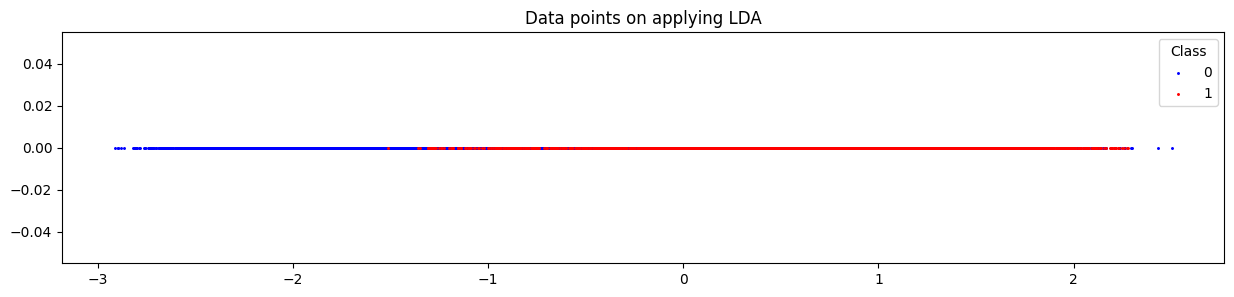

In [ ]:
lda=LDA(n_components=1)
lda.fit(X_train,y_train)
X_train_lda=lda.transform(X_train)
plt.figure(figsize=(15,3))
idx=np.where(y_train==0)[0]
plt.scatter(X_train_lda[idx],np.zeros(len(idx)),c='b',s=1.25,label = "0")
idx=np.where(y_train==1)[0]
plt.scatter(X_train_lda[idx],np.zeros(len(idx)),c='r',s=1.25,label="1")
plt.title("Data points on applying LDA")
plt.legend(title = "Class")
plt.show()

In [ ]:
y_pred=lda.predict(X_val)
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))

Confusion Matrix

 [[346 127]
 [  5  20]]


In [ ]:
print("Classification Report\n\n",classification_report(y_val,y_pred))
model_selection_dict["LDA"] = fbeta_score(y_val,y_pred,beta = beta)

Classification Report

               precision    recall  f1-score   support

           0       0.99      0.73      0.84       473
           1       0.14      0.80      0.23        25

    accuracy                           0.73       498
   macro avg       0.56      0.77      0.54       498
weighted avg       0.94      0.73      0.81       498



In [ ]:
print("fbeta-score",fbeta_score(y_val,y_pred,beta=beta))

fbeta-score 0.40485829959514175


### Logistic Regression CV

In [ ]:
classifier_lda_LR = LogisticRegressionCV(cv=5, random_state = 0, max_iter=1000)
classifier_lda_LR.fit(X_train_lda, y_train.ravel())
y_pred = classifier_lda_LR.predict(lda.transform(X_val))

In [ ]:
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))
model_selection_dict["LDA(LR CV)"] = fbeta_score(y_val,y_pred,beta = beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))

Confusion Matrix

 [[346 127]
 [  5  20]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.99      0.73      0.84       473
      stroke       0.14      0.80      0.23        25

    accuracy                           0.73       498
   macro avg       0.56      0.77      0.54       498
weighted avg       0.94      0.73      0.81       498



In [ ]:
print("f-beta score is",fbeta_score(y_val,y_pred,beta=beta))

f-beta score is 0.40485829959514175


### SVC

In [ ]:
classifier_lda_svc = SVC(kernel='linear',C=50)
classifier_lda_svc.fit(X_train_lda, y_train.ravel())
y_pred = classifier_lda_svc.predict(lda.transform(X_val))

In [ ]:
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))
model_selection_dict["LDA(SVC)"] = fbeta_score(y_val,y_pred,beta = beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))

Confusion Matrix

 [[347 126]
 [  5  20]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.99      0.73      0.84       473
      stroke       0.14      0.80      0.23        25

    accuracy                           0.74       498
   macro avg       0.56      0.77      0.54       498
weighted avg       0.94      0.74      0.81       498



In [ ]:
print("fbeta score",fbeta_score(y_val,y_pred,beta=beta))

fbeta score 0.4065040650406504


## One Class SVM

In [ ]:
clf = OneClassSVM(nu=0.01, kernel="poly", gamma=1)
clf.fit(X_train[y_train==1])
y_pred=clf.predict(X_val)

In [ ]:
y_pred[y_pred==-1]=0
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))
model_selection_dict["One Class SVM"] = fbeta_score(y_val,y_pred,beta = beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))

Confusion Matrix

 [[154 319]
 [  1  24]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.99      0.33      0.49       473
      stroke       0.07      0.96      0.13        25

    accuracy                           0.36       498
   macro avg       0.53      0.64      0.31       498
weighted avg       0.95      0.36      0.47       498



In [ ]:
print('fbeta score is',fbeta_score(y_val,y_pred,beta=beta))

fbeta score is 0.2708803611738149


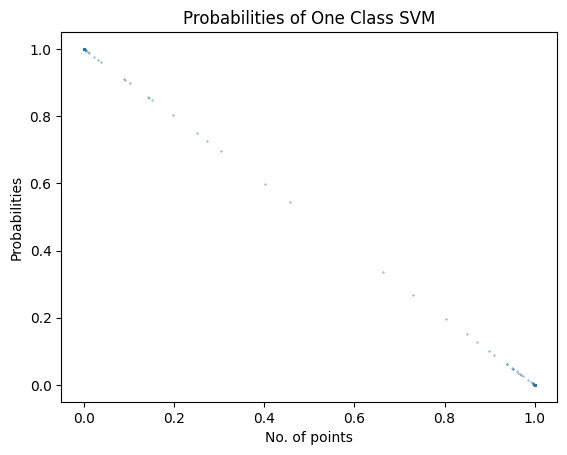

In [ ]:
def platt_scale(oc_svm, X, train_size, cv_size):
	# Get SVM predictions
	y_pred = oc_svm.predict(X)
		
	# Split the data and SVM labels
	X_train, _, y_train, _ = tts(X, y_pred, train_size=train_size)

	# Train using logistic regression with cross-validation 
	lr =LogisticRegressionCV(cv=cv_size,max_iter=1000)
	lr.fit(X_train, y_train)

	return lr.predict_proba(X)


y_pred=platt_scale(clf,X_val,0.7,5)
plt.scatter(y_pred[:,0],y_pred[:,1],s=0.1)
plt.title("Probabilities of One Class SVM")
plt.xlabel("No. of points")
plt.ylabel("Probabilities")
plt.show()

Text(0.5, 1.0, 'Probabilities predicted by one class SVM for false positive points')

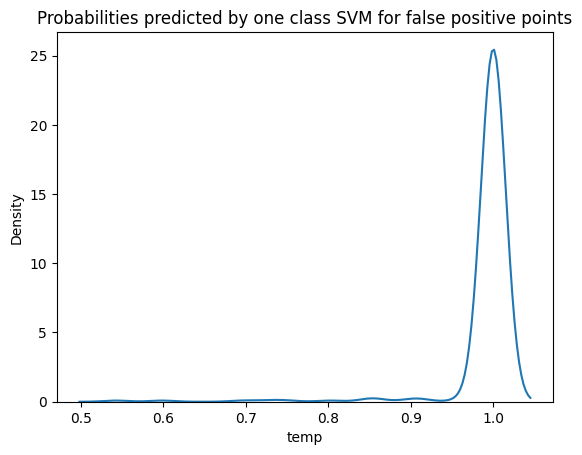

In [ ]:
temp=[]
pred=clf.predict(X_val)
for i in range(len(pred)):
    if(pred[i]==1 and y_val[i]==0):
        temp.append(y_pred[i,1])
        
temp.sort()
# plt.scatter(np.arange(len(temp)),temp)

temp=pd.DataFrame(temp,columns=['temp'])
sns.kdeplot(data=temp,x='temp')
plt.title('Probabilities predicted by one class SVM for false positive points')
# temp

#NN

In [30]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

def custom_loss(y_true, y_pred):
    #Calculating FP,FN,TP,TN
    y_true = K.cast(y_true, dtype=K.floatx())
    FP = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    FN = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TN = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))

    #cross entropy loss
    cross_entropy = K.binary_crossentropy(y_true, y_pred)
    weights_FP = 1.0
    weights_FN = 2.0
    weights_TP = 1.0
    weights_TN = 1.0

    #Calculating loss
    loss = (FP * weights_FP + FN * weights_FN + (1 - TP) * weights_TP + TN * weights_TN) * cross_entropy

    #tf.mean
    loss = K.mean(loss)
    return loss

#Use our previously trained model directly
if os.path.exists('Brain_stroke_model.h5'):
  print("Model Already Downloaded")
else:
  !wget https://www.dropbox.com/s/e81oth92hgaonb4/Brain_stroke_model.h5 -O /dev/null


if os.path.exists('Brain_stroke_model.h5'):
    model = tf.keras.models.load_model('Brain_stroke_model.h5', custom_objects={'custom_loss': custom_loss})
    print("Loading Saved Model")
else:
    model = Sequential()
    model.add(Dense(1024, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    learning_rate = 0.000001
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss=custom_loss, optimizer=optimizer, metrics=['accuracy'])

    # train the model
    for i in range(300):
        model.fit(X_train, y_train, epochs=5, batch_size=128)
        # y_pred = model.predict(X_test)
        # y_pred_classes = (y_pred > 0.5).astype(int)
        # cm = confusion_matrix(y_test, y_pred_classes)
        # print(cm)
        # report = classification_report(y_test, y_pred_classes)
        # print(report)
    
    for i in range(30):
        model.fit(X_train, y_train, epochs=5, batch_size=40)
        # y_pred = model.predict(X_test)
        # y_pred_classes = (y_pred > 0.5).astype(int)
        # cm = confusion_matrix(y_test, y_pred_classes)
        # print(cm)
        # report = classification_report(y_test, y_pred_classes)
        # print(report)

Model Already Downloaded
Loading Saved Model


In [31]:
if os.path.exists('Brain_stroke_model.h5'):
    print("Alreday Present")
else:
    model.save('Brain_stroke_model.h5')
    print("Saving Model")

Alreday Present


In [33]:
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix\n\n",cm)
report = classification_report(y_val, y_pred_classes)
print("Classififcation Report\n\n",report)
print("fbeta score is",fbeta_score(y_val,y_pred_classes,beta=beta))

16/16 [==============================] - 0s 2ms/step
Confusion Matrix

 [[353 120]
 [  5  20]]
Classififcation Report

               precision    recall  f1-score   support

           0       0.99      0.75      0.85       473
           1       0.14      0.80      0.24        25

    accuracy                           0.75       498
   macro avg       0.56      0.77      0.55       498
weighted avg       0.94      0.75      0.82       498

fbeta score is 0.41666666666666663


In [29]:
y_pred

array([[0.6229854 ],
       [0.1673147 ],
       [0.02021282],
       [0.03746421],
       [0.45510018],
       [0.04151024],
       [0.01384192],
       [0.6284763 ],
       [0.18924971],
       [0.1622916 ],
       [0.30812562],
       [0.35191762],
       [0.5457889 ],
       [0.01505265],
       [0.0064568 ],
       [0.00935209],
       [0.2742712 ],
       [0.27541327],
       [0.2187226 ],
       [0.6552279 ],
       [0.6971925 ],
       [0.38037333],
       [0.2621519 ],
       [0.30298358],
       [0.16313723],
       [0.21850796],
       [0.15331288],
       [0.62615514],
       [0.00194622],
       [0.6175991 ],
       [0.08748186],
       [0.01426184],
       [0.1130722 ],
       [0.02817632],
       [0.00622421],
       [0.07007948],
       [0.7703783 ],
       [0.09893492],
       [0.6636833 ],
       [0.8275626 ],
       [0.61276275],
       [0.6959696 ],
       [0.8516366 ],
       [0.00340093],
       [0.20912755],
       [0.7539341 ],
       [0.79823005],
       [0.108

## Extras

20


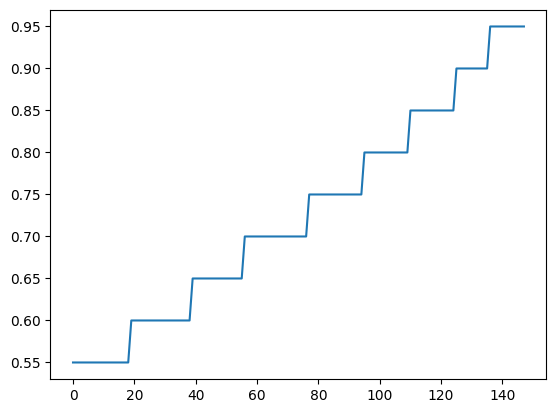

In [ ]:
y_proba_ensemble=pred_proba_ensemble(voting_ensemble,X_val)
y_pred_ensemble=pred_ensemble(voting_ensemble,X_val)
temp=[]
for i in range(len(y_val)):
    if(y_val[i]==0 and y_pred_ensemble[i]==1):
        temp.append(y_proba_ensemble[i,1])
        
temp.sort()
plt.plot(np.arange(len(temp)),temp)

In [ ]:
def plot_roc_curve_ensemble(clf,X,y,classes):
    y_probas=pred_proba_ensemble(clf,X)
    best_thres=0
    best_score=0
    auc_s=[]
    for idx,class_no in enumerate(classes):
        y_true=np.where(y==class_no,1,0)
        y_probs=y_probas[:,idx]
        thresholds=np.sort(y_probs)[::-1]
        tpr=[]
        fpr=[]
        for thres in thresholds:
            y_pred=np.where(y_probs>=thres,1,0)
            tn,fp,fn,tp=confusion_matrix(y_true,y_pred).ravel()
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
            if(best_score<(tp/(tp+fn)-fp/(fp+tn))):
                best_score=(tp/(tp+fn)-fp/(fp+tn))
                best_thres=thres
        auc=np.trapz(tpr,fpr)
        auc_s.append(auc)
        plt.plot(fpr,tpr,label=class_no,alpha=0.5,lw=5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    print("AUC: ",auc_s)
    return best_thres

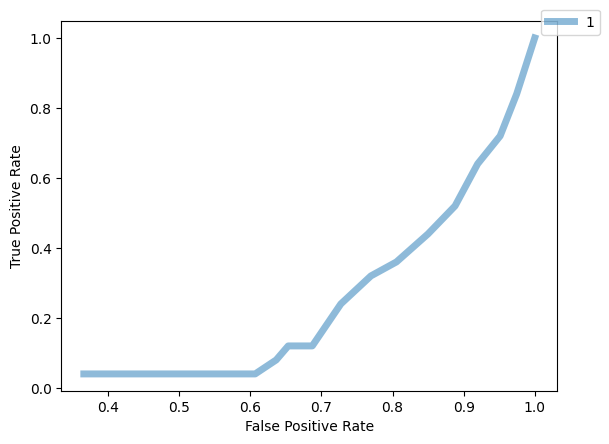

AUC:  [0.16591966173361522]


In [ ]:
thres_ensemble=plot_roc_curve_ensemble(voting_ensemble,X_val,y_val,[1])

In [ ]:
best_f1_score=-1
best_thres=-1
for thres in np.arange(0,1,0.01):
    temp=[1 if y_proba>thres else 0 for y_proba in y_proba_ensemble[:,1]]
    score=f1_score(y_val,temp)
    if(score>best_f1_score):
        best_f1_score=score
        best_thres=thres
        
print(best_f1_score,best_thres)

0.2666666666666667 0.75


In [ ]:
y_pred_ensemble=[1 if y_proba>(best_thres)
                 else 0 for y_proba in y_proba_ensemble[:,1]]
print(confusion_matrix(y_val,y_pred_ensemble))
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred_ensemble,target_names=['not stroke','stroke']))

[[420  53]
 [ 13  12]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.97      0.89      0.93       473
      stroke       0.18      0.48      0.27        25

    accuracy                           0.87       498
   macro avg       0.58      0.68      0.60       498
weighted avg       0.93      0.87      0.89       498



In [ ]:
def sort_dict_by_values(dict):
    sorted_dict = {}
    sorted_keys = sorted(dict, key=dict.get)
    for key in sorted_keys:
        sorted_dict[key] = dict[key]
    return sorted_dict

In [ ]:
sorted_model_selection_dict=sort_dict_by_values(model_selection_dict)
sorted_model_selection_dict

{'Balanced Bagging Classifier': 0.2173913043478261,
 'One Class SVM': 0.2708803611738149,
 'Bagging Classifier': 0.3009259259259259,
 'XGB Classifier': 0.36303630363036304,
 'K-Nearest Neighbour Classifier': 0.3818181818181819,
 'SVC(oversampled)': 0.398406374501992,
 'LDA': 0.40485829959514175,
 'LDA(LR CV)': 0.40485829959514175,
 'LDA(SVC)': 0.4065040650406504,
 'Voting Emsemble': 0.40740740740740744,
 'Logistic Regression': 0.41501976284584974,
 'MLP Classifier': 0.4260089686098655,
 'Naive Bayes(Complement)': 0.42986425339366524,
 'SVC(undersampled)': 0.4423076923076923}